## Data Preprocessing

This notebook can be used to produce smaller versions of the Quark Gluon Dataset.
I used it to produce the 12x12 and 40x40 ECAL datasets.

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from matplotlib.colors import LogNorm

2022-09-23 19:31:15.860903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 19:31:15.860919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## load data 

In [2]:
f3 = h5py.File("../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
f2 = h5py.File("../data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")
f = h5py.File("../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")

There are three files:
- f3: ~800000 samples
- f2: ~140000 samples
- f: 10000 samples

In [3]:
x_train = f3.get('X_jets')
y_train = f3.get('y')

x_val = f2.get('X_jets')
y_val = f2.get('y')

x_test = f.get('X')
y_test = f.get('y')

We will just name the dataset to reduce as `x_red`

In [4]:
x_red = f.get('X')
y_red = f.get('y')

## resize and safe to new file

The different methods that can be used to reduce the dimension. 
Usually cropping first and then resizing should be the best.

In [5]:
def crop(x, channel, crop_fraction):
    return tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)

def simple_resize(x, channel, scale, meth="bilinear"):
    return tf.image.resize(x[:,:,:,channel].reshape((x.shape[0],125,125,1)), (scale,scale), method=meth).numpy()

def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

Fix some settings:

- batch size: how many samples to load into memory at once
- file name: name of output file
- output shape: shape the rescale images should have
- channel: which channel to use (in this case only ecal) - you could also rewrite to use all channels
- crop fraction: To what percent to crop down before rescaling

In [6]:
batch_size = 25
num_batches = x_red.shape[0] // batch_size
events = num_batches * batch_size
file_name = "QG_rescaled"
channel = 1
crop_fraction = 0.8

output_shape = (12,12)

In [7]:
fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,) + output_shape, dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')


for i in range(int(num_batches)):
    y = y_red[i * batch_size: (i + 1) * batch_size]
    x = x_red[i * batch_size: (i + 1) * batch_size]

    x_small = crop_and_resize(x, channel, output_shape[0], crop_fraction=crop_fraction)
    
    div1 = np.max(x_small, axis=(1,2)).reshape((x.shape[0],1,1,1))
    div1[div1 == 0] = 1
    x_small = x_small / div1

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_small.reshape((x_small.shape[0],)+output_shape)
    print("batch ",i,"/",num_batches, end="\r")
    
fnew.close()

2022-09-23 19:31:17.432170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 19:31:17.432188: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 19:31:17.432203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-09-23 19:31:17.432419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## verify scaling

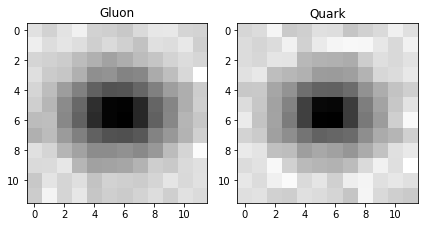

In [8]:
test = h5py.File(file_name,"r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='binary')
axs[0].title.set_text('Gluon')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='binary')
axs[1].title.set_text('Quark')

fig.tight_layout()

test.close()